# 0.Loading Packages

In [100]:
import pandas as pd 
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_error
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

# 1.Reading data and data cleaning 
First let's clean data and handle missing data(if there exist)
<br>


In [101]:
data = pd.read_csv('psi_df_2016_2019.csv')
data

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00
...,...,...,...,...,...,...,...
30017,76,78,72,74,78,71,2019-11-06T10:00:00+08:00
30018,75,77,71,73,77,71,2019-11-06T11:00:00+08:00
30019,74,77,71,73,77,71,2019-11-06T12:00:00+08:00
30020,74,78,72,73,78,71,2019-11-06T13:00:00+08:00


Convert timestamp to numerical timestamp

In [102]:
from dateutil.parser import parse
from datetime import datetime

def convert(date):
    holder = []
    for i in date:
        tp = parse(i).timestamp()
        dt = datetime.fromtimestamp(tp)
        holder.append(dt)
    return np.array(holder)

In [103]:
date = data['timestamp'].values
date_num = convert(date)
# sanity check
print(len(date_num) == data.shape[0])

True


In [5]:
data['timestamp'] = date_num
data.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07 13:30:00
1,59,57,54,59,57,56,2016-02-08 18:30:00
2,59,57,55,59,57,56,2016-02-08 20:30:00
3,59,57,55,59,56,56,2016-02-08 21:30:00
4,59,58,55,59,56,56,2016-02-08 22:30:00


In [6]:
#set date(timestamp) as index 
data.head()
data = data.set_index('timestamp')
data.head()

,national,south,north,east,central,west
timestamp,,,,,,
2016-02-07 13:30:00,47,44,37,47,47,34
2016-02-08 18:30:00,59,57,54,59,57,56
2016-02-08 20:30:00,59,57,55,59,57,56
2016-02-08 21:30:00,59,57,55,59,56,56
2016-02-08 22:30:00,59,58,55,59,56,56


Checking for Missing value in all columns

In [16]:
# check the missing values
data.isnull().any()

national    False
south       False
north       False
east        False
central     False
west        False
dtype: bool

# 2.Visualization and data exploration 
Before going through the regression code, we can take a look on how data looks like.

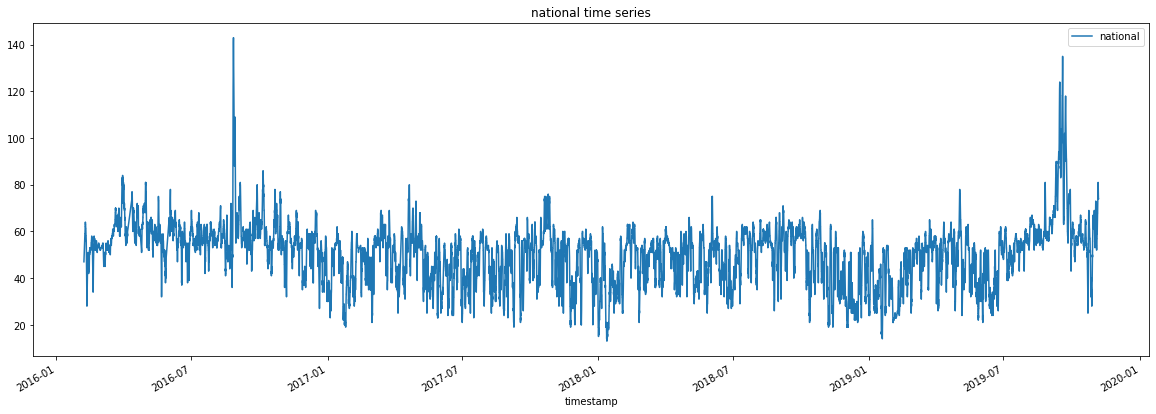

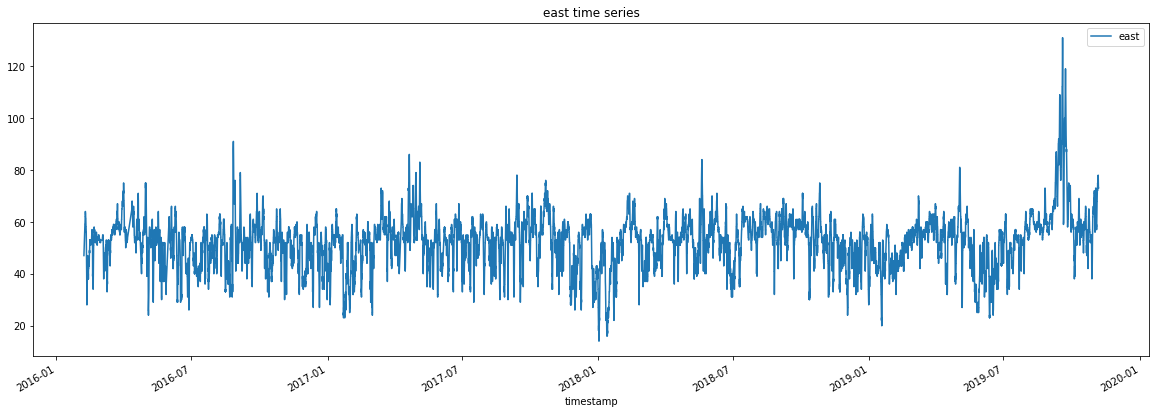

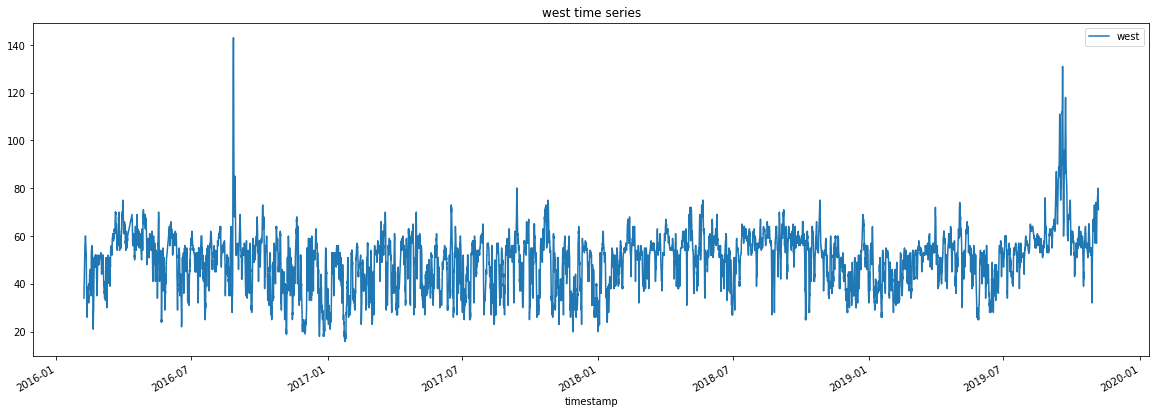

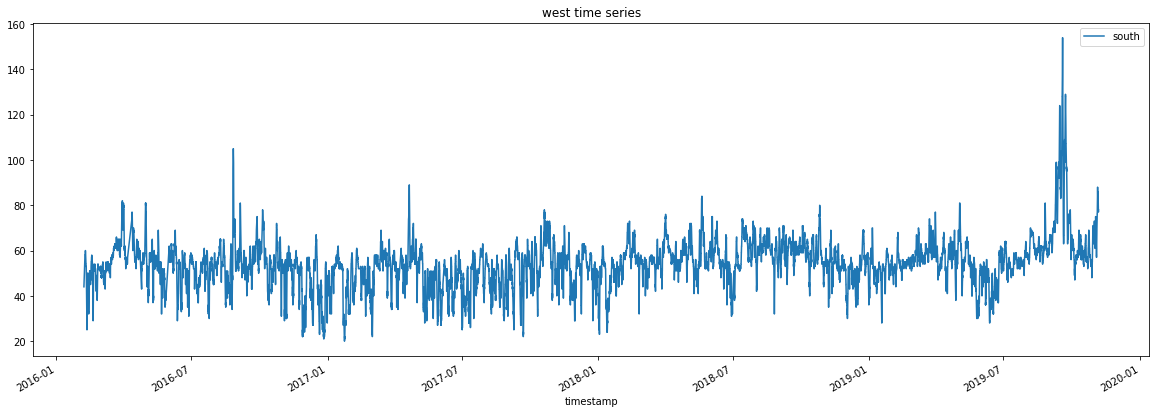

In [17]:
#visualization of time series 
plt.figure(num=None, figsize=(20, 15))
plt.subplot(2, 1, 1)
ax = data['national'].plot(style=['-'])
plt.title("national time series")
ax.legend()
plt.show()
plt.figure(num=None, figsize=(20, 15))
plt.subplot(2, 1, 2)
ax = data['east'].plot(style=['-'])
plt.title("east time series")
ax.legend()
plt.show()
plt.figure(num=None, figsize=(20, 15))
plt.subplot(2, 1, 2)
ax = data['west'].plot(style=['-'])
plt.title("west time series")
ax.legend()
plt.show()
plt.figure(num=None, figsize=(20, 15))
plt.subplot(2, 1, 2)
ax = data['south'].plot(style=['-'])
plt.title("west time series")
ax.legend()
plt.show()

Check histogram and density plots(checking nomality)

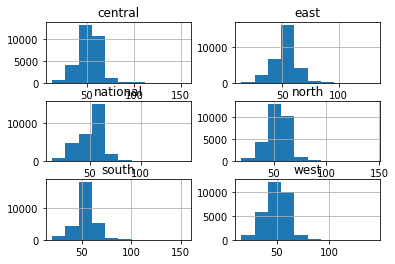

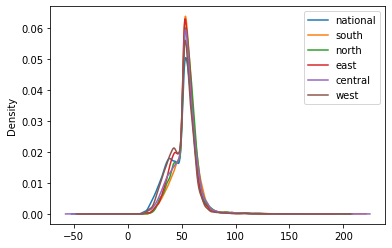

In [18]:
#histogram and density plots
data.hist()
data.plot(kind='kde')

Statistical variables (and per year) : 

In [19]:
#summarize data with statistical variables
data.describe(include = 'all')

,national,south,north,east,central,west
count,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000
mean,50.502232,54.294351,54.003464,52.491007,52.885884,50.299014
std,13.107219,10.844489,10.991413,10.365553,11.832203,11.672157
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000


acourding to following table,there was a meaningful change in mean(per year)

In [21]:
#per year mean (2016 - 2017 - 2018 - 2019)
date_serie = data.groupby(pd.Grouper(freq="Y"))
date_serie.agg([np.mean])

,national,south,north,east,central,west
,mean,mean,mean,mean,mean,mean
timestamp,,,,,,
2016-12-31,57.690431,52.672316,55.517166,50.934843,51.122717,49.888093
2017-12-31,46.986609,49.951843,55.002334,52.151351,50.714496,46.014988
2018-12-31,47.016377,56.396650,51.222705,52.594045,53.730893,52.352357
2019-12-31,51.578615,58.523434,54.565429,54.294969,56.172854,53.328221


Lag Plot to explore the relationship between each observation and a lag of that observation :

No handles with labels found to put in legend.


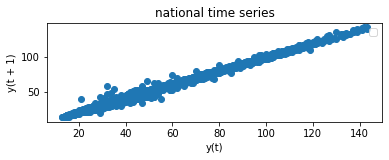

No handles with labels found to put in legend.


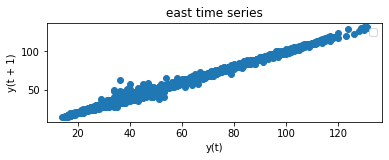

No handles with labels found to put in legend.


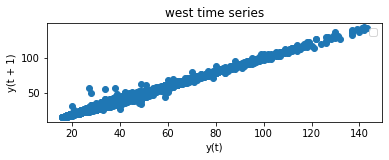

No handles with labels found to put in legend.


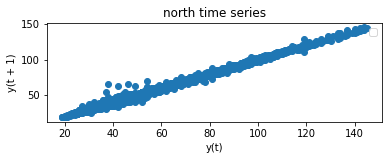

No handles with labels found to put in legend.


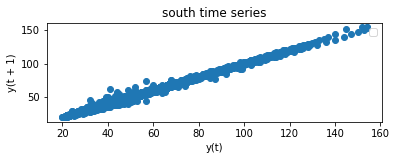

No handles with labels found to put in legend.


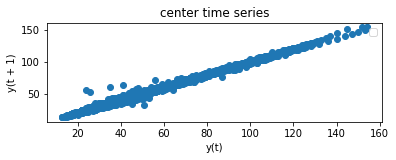

In [32]:
#using lag plot (edit to all plots in this line)

plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['national'])
plt.title("national time series")
ax.legend()
plt.show()
plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['east'])
plt.title("east time series")
ax.legend()
plt.show()
plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['west'])
plt.title("west time series")
ax.legend()
plt.show()
plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['north'])
plt.title("north time series")
ax.legend()
plt.show()
plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['south'])
plt.title("south time series")
ax.legend()
plt.show()
plt.figure(num=None)
plt.subplot(2, 1, 1)
ax = lag_plot(data['central'])
plt.title("center time series")
ax.legend()
plt.show()

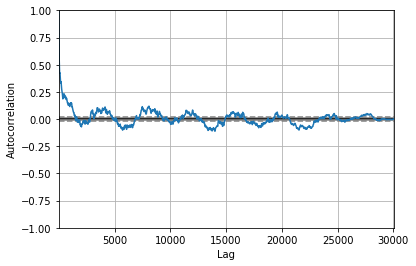

In [74]:
#autocorrelation plot
autocorrelation_plot(data)
pyplot.show()

autocorrelation plot, a strong sign of seasonality in data

# 3. Using LSTM for prediction
<br>
Using keras for LSTM then split test and train data: 

In [71]:
# Prepare data fot LSTM net
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

split test and train data and reshape data for LSTM 

In [72]:
# define input sequence
raw_seq = data['east'].values
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
#split test and train data
X_train, X_test = X[:25000] , X[25000:]
y_train, y_test = y[:25000], y[25000:]

In [73]:
# define LSTM model
model = Sequential()
model.add(LSTM(70, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Train on 25000 samples, validate on 5018 samples
Epoch 1/50
25000/25000 [==============================] - 9s 353us/step - loss: 111.2700 - val_loss: 1.5381
Epoch 2/50
25000/25000 [==============================] - 7s 281us/step - loss: 1.7874 - val_loss: 1.0155
Epoch 3/50
25000/25000 [==============================] - 7s 299us/step - loss: 1.2486 - val_loss: 1.0646
Epoch 4/50
25000/25000 [==============================] - 7s 280us/step - loss: 1.2416 - val_loss: 1.0579
Epoch 5/50
25000/25000 [==============================] - 7s 294us/step - loss: 1.2303 - val_loss: 0.9456
Epoch 6/50
25000/25000 [==============================] - 7s 278us/step - loss: 1.2161 - val_loss: 0.9306
Epoch 7/50
25000/25000 [==============================] - 7s 281us/step - loss: 1.2070 - val_loss: 0.9571
Epoch 8/50
25000/25000 [==============================] - 7s 280us/step - loss: 1.1848 - val_loss: 0.9697
Epoch 9/50
25000/25000 [==============================] - 8s 310us/step - loss: 1.1261 - val_loss: 0.

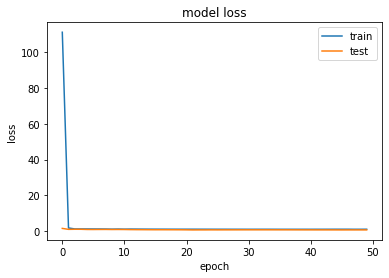

In [74]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=50, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

train and test curve seems good, as the validation curve reaches the lowest value and there is no overfitting. 
<br>
Evaluate Models:

In [75]:
# make a prediction
yhat = model.predict(X_test, verbose=0)
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.840


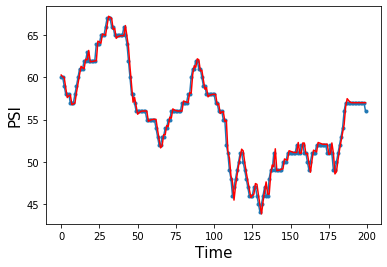

In [76]:
#plot prediction and actual time series 
day_indx=[x for x in range(200)]
plt.plot(day_indx, y_test[:200], marker='.', label="actual")
plt.plot(day_indx, yhat[:200], 'r', label="prediction")
plt.ylabel('PSI', size=15)
plt.xlabel('Time', size=15)
plt.show()

Now use this model for predict other columns:

In [87]:
def predict(column):
    # define input sequence
    raw_seq = data[column].values
    # choose a number of time steps
    n_steps = 4
    # split into samples
    X, y = split_sequence(raw_seq, n_steps)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    #split test and train data
    X_train, X_test = X[:25000] , X[25000:]
    y_train, y_test = y[:25000], y[25000:]
    
    # define LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(70, activation='relu', input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # fit network
    history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    #predict
    y_hat = lstm_model.predict(X_test, verbose=0)
    
    #evaluate
    #plot prediction and actual time series 
    day_indx=[x for x in range(200)]
    plt.plot(day_indx, y_test[:200], marker='.', label="actual")
    plt.plot(day_indx, y_hat[:200], 'r', label="prediction")
    plt.ylabel('PSI', size=15)
    plt.xlabel('Time', size=15)
    plt.title(column)
    plt.show()
    
    return y_hat

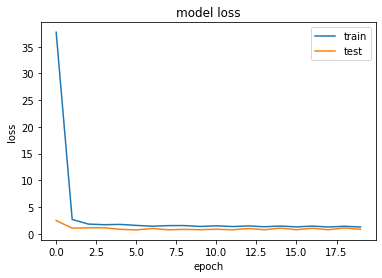

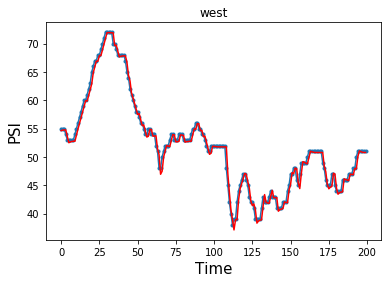

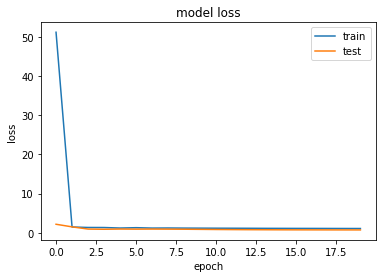

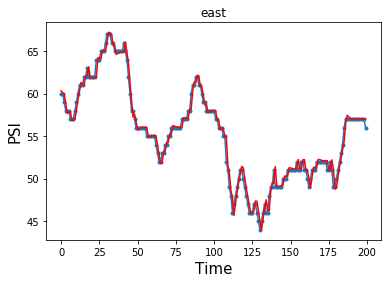

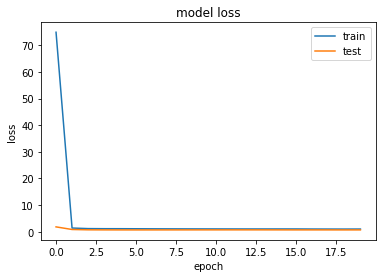

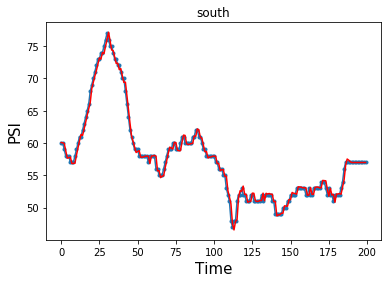

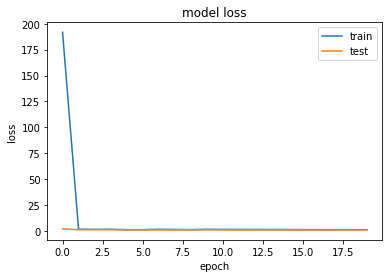

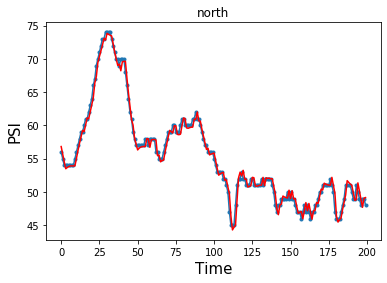

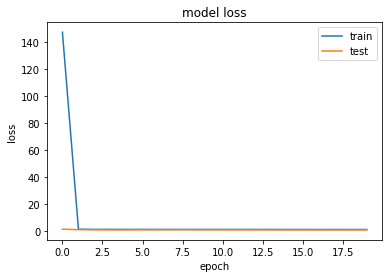

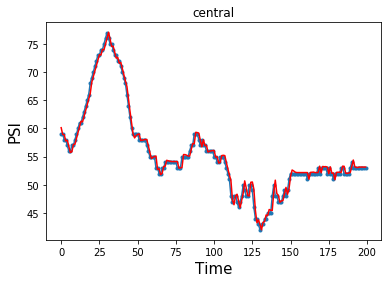

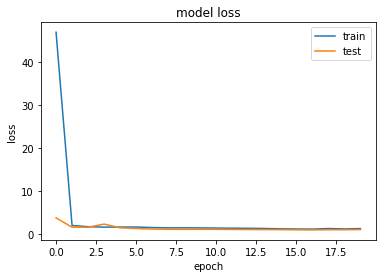

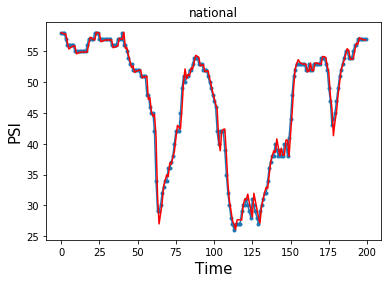

In [88]:
west_pr = predict("west")
east_pr = predict("east")
south_pr = predict("south")
north_pr = predict("north")
central_pr = predict("central")
national_pr = predict("national")

Save result as dataframe and csv 

In [97]:
result = pd.DataFrame(columns = ['west','east','south', 'north', 'central','national'])
result['west'] = west_pr.tolist()
result['east'] = east_pr.tolist()
result['central'] = central_pr.tolist()
result['north'] = north_pr.tolist()
result['south'] = south_pr.tolist()
result['national'] = national_pr.tolist()


In [98]:
result

,west,east,south,north,central,national
0,[54.64601135253906],[60.32962417602539],[60.070735931396484],[56.81745147705078],[60.1358642578125],[58.02880859375]
1,[54.730918884277344],[60.10722732543945],[60.04286193847656],[55.641761779785156],[58.93222427368164],[57.9487190246582]
2,[54.76641845703125],[59.96696090698242],[59.923343658447266],[54.520755767822266],[58.890602111816406],[57.838138580322266]
3,[54.76641845703125],[58.807533264160156],[58.77718734741211],[53.479087829589844],[57.777408599853516],[57.838138580322266]
4,[53.61459732055664],[57.67301559448242],[57.66212463378906],[53.67118453979492],[57.90839385986328],[56.57024383544922]
...,...,...,...,...,...,...
5013,[71.8304443359375],[73.19715118408203],[79.15565490722656],[71.58506774902344],[79.47866821289062],[75.04666137695312]
5014,[70.7674560546875],[73.45755767822266],[77.00005340576172],[70.70647430419922],[77.13825225830078],[75.27098083496094]
5015,[70.83171081542969],[72.44246673583984],[75.91441345214844],[69.88916015625],[76.12509155273438],[74.09254455566406]
5016,[70.86347961425781],[72.58660125732422],[76.10795593261719],[70.18900299072266],[76.4791030883789],[72.90161895751953]


In [99]:
result.to_csv("result.csv")